<a href="https://colab.research.google.com/github/rinazbelhaj/EVA/blob/master/Project%207/Assignment%207B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 3s 0us/step


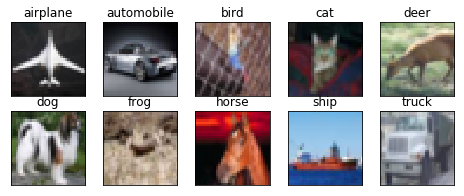

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

# Modified Network

1.   Design the following network for CIFAR10
![alt+text](https://github.com/rinazbelhaj/EVA/blob/master/Images/ENAS.PNG?raw=true "ENAS")
2.   The lines you see are the skip-connections
3.   Train for 100 Epochs (add BN and ReLU after every layer)


ENAS Paper : https://arxiv.org/pdf/1802.03268.pdf

In [0]:
## MAIN BLOCK

from keras.layers import Activation
from keras.layers.merge import concatenate,add
from keras.models import Model
from keras.layers import Reshape,Activation,Conv2D,Input,MaxPooling2D,BatchNormalization,Flatten,SeparableConv2D,Lambda,GlobalAveragePooling2D
import tensorflow as tf

def sd2(x):
    return tf.space_to_depth(x, block_size=2)

def sd4(x):
    return tf.space_to_depth(x, block_size=4)
  
input = Input(shape=(32,32,3),name="input")

# Block 1 : Jump 1 
c1  = SeparableConv2D(32, (5,5), activation='relu',padding='same', name='c1')(input) 
c1  = BatchNormalization(name='bn_1')(c1)      # RF - (5,5)

c2  = Conv2D(32, (5,5), activation='relu',padding='same', name='c2')(c1)
c2  = BatchNormalization(name='bn_2')(c2)      # RF - (9,9)

c3  = Conv2D(32, (5,5), activation='relu',padding='same', name='c3')(c2)
c3  = BatchNormalization(name='bn_3')(c3)      # RF - (14,14)

c4  = SeparableConv2D(32, (5,5), activation='relu',padding='same', name='c4')(concatenate([c3,c1],name='concat_4'))
c4  = BatchNormalization(name='bn_4')(c4)      # RF - (18,18)

m1  = MaxPooling2D(pool_size=(2, 2),name='m1')(concatenate([c4,c1],name='concat_2'))  
                                               # RF - (19,19)

# Block 2 : Jump 2 
c5  = SeparableConv2D(64, (3,3), activation='relu',padding='same', name='c5')(m1) 
c5  = BatchNormalization(name='bn_5')(c5)      # RF - (23,23)

c6  = Conv2D(64, (5,5), activation='relu',padding='same', name='c6')(concatenate([c5,Lambda(sd2,name='sd_6a')(c1),Lambda(sd2,name='sd_6b')(c4)],name='concat_6'))           
c6  = BatchNormalization(name='bn_6')(c6)      # RF - (31,31)

c7  = SeparableConv2D(64, (3,3), activation='relu',padding='same', name='c7')(concatenate([c6,Lambda(sd2,name='sd_7a')(c3),Lambda(sd2,name='sd_7b')(c4),c5],name='concat_7')) 
c7  = BatchNormalization(name='bn_7')(c7)      # RF - (35,35)

c8  = SeparableConv2D(64, (5,5), activation='relu',padding='same', name='c8')(concatenate([c7,Lambda(sd2,name='sd_8a')(c1),Lambda(sd2,name='sd_8b')(c3),Lambda(sd2,name='sd_8c')(c4),c5,c6],name='concat_8'))       
c8  = BatchNormalization(name='bn_8')(c8)      # RF - (43,43)

m2  = MaxPooling2D(pool_size=(2, 2),name='m2')(concatenate([c8,Lambda(sd2,name='sd_m2a')(c1),Lambda(sd2,name='sd_m2b')(c4),c5,c7],name='concat_m2')) 
                                               # RF - (45,45) 

# Block 3 : Jump 4 [Grouped Convolution with different kernels]
c9  = Conv2D(128, (5,5), activation='relu',padding='same', name='c9')(concatenate([m2,Lambda(sd2,name='sd_9a')(c6)],name='concat_9'))        
c9  = BatchNormalization(name='bn_9')(c9)      # RF - (61,61)

c10 = SeparableConv2D(128, (5,5), activation='relu',padding='same', name='c10')(concatenate([c9,Lambda(sd4,name='sd_10a')(c1),Lambda(sd4,name='sd_10b')(c2),Lambda(sd4,name='sd_10c')(c4),Lambda(sd2,name='sd_10d')(c7)],name='concat_10'))  
c10 = BatchNormalization(name='bn_10')(c10)    # RF - (77,77)

c11  = Conv2D(128, (3,3), activation='relu',padding='same', name='c11')(concatenate([c10,Lambda(sd4,name='sd_11a')(c2),Lambda(sd4,name='sd_11b')(c3),Lambda(sd2,name='sd_11c')(c5),c9],name='concat_11')) 
c11  = BatchNormalization(name='bn_11')(c11)   # RF - (85,85)

c12  = SeparableConv2D(128, (5,5), activation='relu',padding='same', name='c12')(concatenate([c11,Lambda(sd4,name='sd_12a')(c3),Lambda(sd4,name='sd_12b')(c4),Lambda(sd2,name='sd_12c')(c5),Lambda(sd2,name='sd_12d')(c7),c10],name='concat_12'))             
                                               # RF - (101,101)
c12_c = Conv2D(10, (1,1), activation=None,padding='same', name='c12_c')(concatenate([c12,Lambda(sd4,name='sd_12_fa')(c4),Lambda(sd2,name='sd_12_fb')(c7),c10],name='concat_12_c'))
                                               # RF - (101,101)
c12_f = GlobalAveragePooling2D(name='GAP')(c12_c) 
output = Activation('softmax',name='final')(c12_f)

model = Model(inputs=[input], outputs=[output])


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
c1 (SeparableConv2D)            (None, 32, 32, 32)   203         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 32, 32, 32)   128         c1[0][0]                         
__________________________________________________________________________________________________
c2 (Conv2D)                     (None, 32, 32, 32)   25632       bn_1[0][0]                       
__________________________________________________________________________________________________
bn_2 (Batc

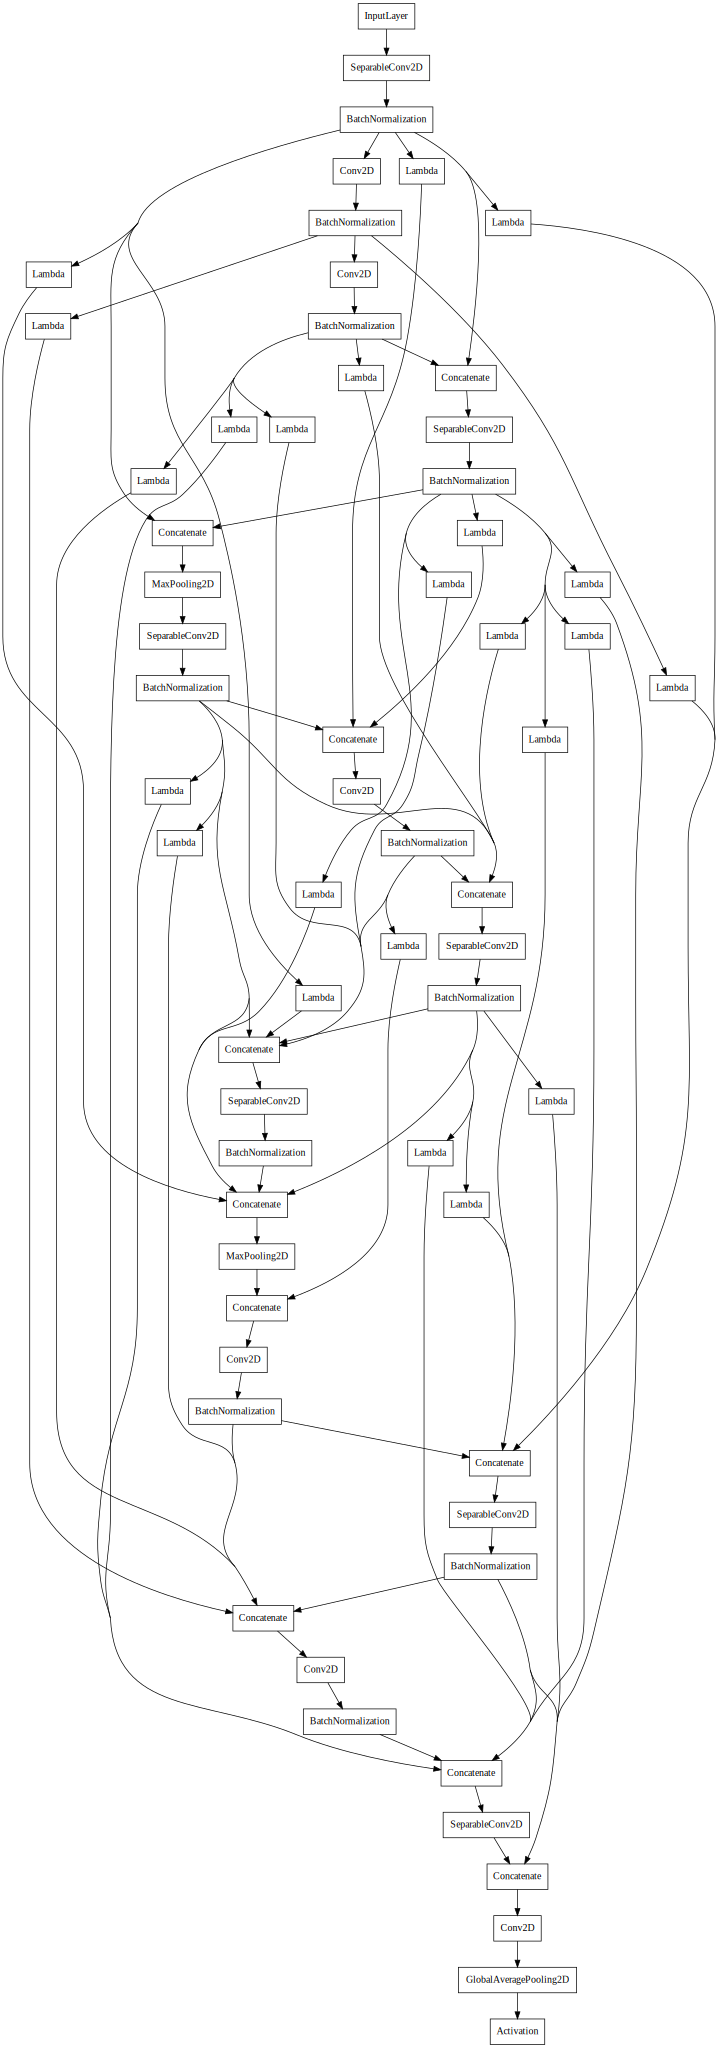

In [0]:
## Network Architecture

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,show_shapes=False,show_layer_names=False).create(prog='dot', format='svg'))

Epoch 1/100
390/390 [==============================] - 122s 314ms/step - loss: 1.2249 - acc: 0.5560 - val_loss: 1.0744 - val_acc: 0.6390
Epoch 2/100
390/390 [==============================] - 117s 300ms/step - loss: 0.7838 - acc: 0.7242 - val_loss: 0.9411 - val_acc: 0.6967
Epoch 3/100
390/390 [==============================] - 117s 300ms/step - loss: 0.5783 - acc: 0.7960 - val_loss: 0.8985 - val_acc: 0.7034
Epoch 4/100
390/390 [==============================] - 117s 300ms/step - loss: 0.4361 - acc: 0.8486 - val_loss: 0.7407 - val_acc: 0.7654
Epoch 5/100
390/390 [==============================] - 116s 298ms/step - loss: 0.3094 - acc: 0.8922 - val_loss: 0.6911 - val_acc: 0.7889
Epoch 6/100
390/390 [==============================] - 117s 300ms/step - loss: 0.2087 - acc: 0.9268 - val_loss: 0.8560 - val_acc: 0.7760
Epoch 7/100
390/390 [==============================] - 117s 299ms/step - loss: 0.1409 - acc: 0.9515 - val_loss: 0.8525 - val_acc: 0.7891
Epoch 8/100
390/390 [====================

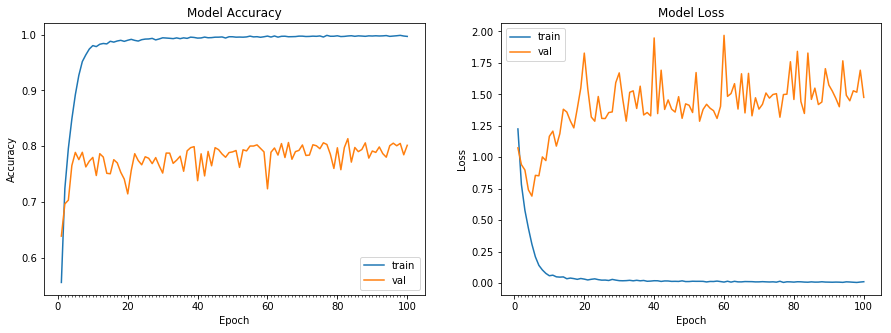

Accuracy on test data is: 80.16


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 steps_per_epoch = train_features.shape[0]//128, epochs = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))